In [1]:
import numpy as np
import os
os.chdir('../')
import matplotlib.pyplot as plt
%matplotlib inline

### 一.简介
今天将介绍另一种简单的线性二分类模型：感知机(Perceptron)，它的要求比较松，只要能找到一个超平面将正负样本分割开就行！它的目标函数形式也简单：  

$$
f(x)=sign(w^Tx^*)
$$  
同样，这里$x^*=[x^T,1]^T$，$sign$表示符号函数，对于$t\geq 0$,有$sign(t)=1$，反之$sign(t)=-1$  

损失函数可以定义为误分类点的数量，但该变量不是关于$w$的连续可导函数，我们可以放松条件定义如下：  

$$
L(w)=-\sum_{(x_i,y_i)\in M}{y_i(w^Tx_i^*)}
$$  

这里$M$表示误分类点的集合，显然$w^Tx_i^*$与$y_i$始终异号；关于$w$的梯度非常容易求解，但感知机模型通常是使用随机梯度下降，即从$M$中随机选取一个点$(x_i,y_i)$进行更新，一直迭代直到$M$为空：  

$$
w=w+\eta y_ix_i^*
$$

### 二.代码实现

In [2]:
class Perceptron(object):
    def __init__(self, epochs=10, eta=None):
        self.w = None
        self.epochs = epochs
        self.eta = eta

    def init_params(self, n_features):
        """
        初始化参数
        :return:
        """
        self.w = np.random.random(size=(n_features + 1, 1))

    def fit(self, x, y):
        """
        :param x: ndarray格式数据: m x n
        :param y: ndarray格式数据: m x 1
        :return:
        """
        # 设置学习率
        if self.eta is None:
            self.eta = max(1e-2, 1.0 / np.sqrt(x.shape[0]))
        y = y.reshape(-1, 1)
        y[y == 0] = -1
        # 初始化参数w,b
        n_samples, n_features = x.shape
        self.init_params(n_features)
        x = np.c_[x, np.ones(shape=(n_samples,))]
        x_y = np.c_[x, y]

        for _ in range(self.epochs):
            error_sum = 0
            np.random.shuffle(x_y)
            for index in range(0, n_samples):
                x_i = x_y[index, :-1]
                y_i = x_y[index, -1:]
                # 更新错分点的参数
                if (x_i.dot(self.w) * y_i)[0] < 0:
                    dw = (-x_i * y_i).reshape(-1, 1)
                    self.w = self.w - self.eta * dw
                    error_sum += 1
            if error_sum == 0:
                break

    def get_params(self):
        """
        输出原始的系数
        :return: w
        """

        return self.w

    def predict(self, x):
        """
        :param x:ndarray格式数据: m x n
        :return: m x 1
        """
        n_samples = x.shape[0]
        x = np.c_[x, np.ones(shape=(n_samples,))]
        return (x.dot(self.w) > 0).astype(int)

    def predict_proba(self, x):
        """
        :param x:ndarray格式数据: m x n
        :return: m x 1
        """
        n_samples = x.shape[0]
        x = np.c_[x, np.ones(shape=(n_samples,))]
        return utils.sigmoid(x.dot(self.w))

    def plot_decision_boundary(self, x, y):
        """
        绘制前两个维度的决策边界
        :param x:
        :param y:
        :return:
        """
        weights = self.get_params()
        w1 = weights[0][0]
        w2 = weights[1][0]
        bias = weights[-1][0]
        x1 = np.arange(np.min(x), np.max(x), 0.1)
        x2 = -w1 / w2 * x1 - bias / w2
        plt.scatter(x[:, 0], x[:, 1], c=y, s=50)
        plt.plot(x1, x2, 'r')
        plt.show()

### 三.校验

In [3]:
from sklearn.datasets import make_classification
data,target=make_classification(n_samples=200, n_features=2,n_classes=2,n_informative=1,n_redundant=0,n_repeated=0,n_clusters_per_class=1)

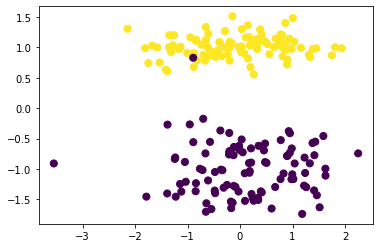

In [4]:
plt.scatter(data[:, 0], data[:, 1], c=target,s=50)

In [5]:
#训练模型
perceptron = Perceptron()
perceptron.fit(data, target)

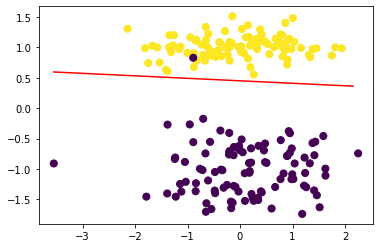

In [6]:
perceptron.plot_decision_boundary(data,target)

### 四.感知机的另一种实现-对偶形式
如果初始$w=0$，根据上方参数更新公式$w=w+\eta y_ix_i$，可以知道$w$其实是$\{y_1x_1,y_2x_2,...,y_Nx_N\}$的线性组合（$N$表示训练样本量），所以$w$可以表示为：  

$$
w=\sum_{i=1}^N\alpha_i y_ix_i
$$  

所以对于原始优化变量$w$的求解，改变为对优化变量$\alpha=[\alpha_1,\alpha_2,...,\alpha_N]^T$的求解；原来对于误分类点$(x_i,y_i)$的参数更新公式$w=w+\eta y_ix_i$可以换成：  

$$
\alpha_i=\alpha_i+\eta
$$  

下面就简单对对偶形式进行代码实现，并嵌入到`fit`函数中:  
```python
def __init__(self,...,mode=None):
    self.mode=mode
    ...
def fit(self, x, y):
    if self.mode=='dual':
        self._dual_fit(x,y,epochs,eta)
    else:
       #继续原始的代码
       ...
```

In [7]:
   def _dual_fit(self, x, y):
        """
        模型训练的对偶形式
        :param x:
        :param y:
        :return:
        """
        y = y.reshape(-1, 1)
        y[y == 0] = -1

        n_samples, n_features = x.shape

        # 初始化参数
        self.alpha = np.zeros(shape=(n_samples, 1))

        x = np.c_[x, np.ones(shape=(n_samples,))]

        for _ in range(self.epochs):
            error_sum = 0
            indices = list(range(0, n_samples))
            np.random.shuffle(indices)
            for index in indices:
                x_i = x[index, :]
                y_i = y[index]
                # 更新错分点的参数，（注意需要有等号，因为初始化的alpha全为0）
                if (x_i.dot(x.T.dot(self.alpha * y)) * y_i)[0] <= 0:
                    self.alpha[index] += self.eta
                    error_sum += 1
            if error_sum == 0:
                break
        # 更新回w
        self.w = x.T.dot(alpha * y)

In [8]:
#测试
from ml_models.linear_model import Perceptron
perceptron = Perceptron(mode='dual')
perceptron.fit(data, target)

ModuleNotFoundError: No module named 'ml_models'

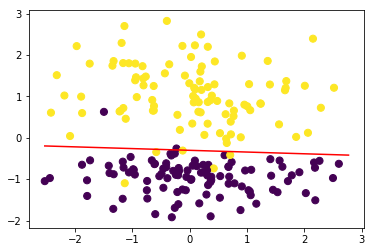

In [ ]:
#可以发现结果几乎一致
perceptron.plot_decision_boundary(data,target)

对偶形式的模型参数数量与训练样本量相当,对于海量训练样本而言，这样的参数数量无法接受，而且训练会很慢，那我们进一步考虑一下，这些参数中真正发挥作用的有多少呢？

In [ ]:
np.sum(perceptron.alpha!=0)/len(perceptron.alpha)

在所有训练样本中，真正能对模型提供帮助的其实仅占很少一部分，可以这样理解，当某个离决策超平面近的样本点满足某个条件时(大于0或者小于0)，和该样本点同侧且距离更远的样本自然也满足该条件，所以这些距离超平面远的点其实对模型没有帮助，所以我们只需要找到离决策超平面最近的几个样本点就可以将模型确定，这便是**支撑向量机(SVM)**的思想，我将在后续内容中进行介绍~~~